In [1]:
import os
import matplotlib.pyplot as plt
import librosa.display
import random

import numpy as np
import librosa
import skimage.io

from skimage.color import rgb2gray
import cv2
from PIL import Image
from skimage import io
from skimage.feature import local_binary_pattern
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold

plt.style.use('seaborn-white')

In [2]:
entrada = "./data_2016/TUT-acoustic-scenes-2016-development/meta.txt"

classes = ["beach","bus","cafe_restaurant","car","city_center","forest_path","grocery_store","home","library","metro_station","office","park","residential_area","train","tram"]
classes_int = [i for i in range(15)]

classe_caminho = []


arq = open(entrada)
linhas = arq.readlines()
for i in linhas:
    aux = i.split("	")
    aux2 = aux[1].replace("\n", "")
    aux2 = aux2.replace("/", "_")
    aux2 += ";"
    aux2 += aux[0]
    classe_caminho.append(aux2)

classe_caminho.sort()

FileNotFoundError: [Errno 2] No such file or directory: './data_2016/TUT-acoustic-scenes-2016-development/meta.txt'

In [3]:
class LocalBinaryPatterns2:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        lbp = local_binary_pattern(
            image, self.numPoints, self.radius, method="nri_uniform")
        n_bins = int(lbp.max() + 1)
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))

        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

def carregar_audio(path):
    audio, sr = librosa.load(path)
    print(sr)

    janela_segundos = 5

    janela_amostras = int(janela_segundos * sr)

    janelas = librosa.util.frame(audio, frame_length=janela_amostras, hop_length=janela_amostras)

    return janelas.T

In [4]:
aux = classe_caminho[0].split(";")
path = aux[1]
path = "./data_2016/TUT-acoustic-scenes-2016-development/" + path
imgs = carregar_audio(path)

22050


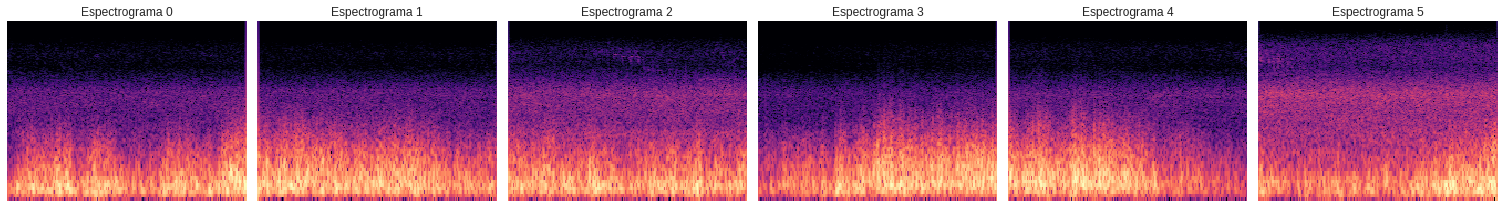

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(21, 3))

for i, janela in enumerate(imgs):
    espectrograma = librosa.stft(janela)
    axs[i].axis('off')
    vmin = np.min(espectrograma)
    librosa.display.specshow(librosa.amplitude_to_db(abs(espectrograma), ref=np.max), sr=22050, y_axis='log', x_axis='time', ax=axs[i])
    axs[i].set_title(f'Espectrograma {i}')

plt.tight_layout()
plt.show()

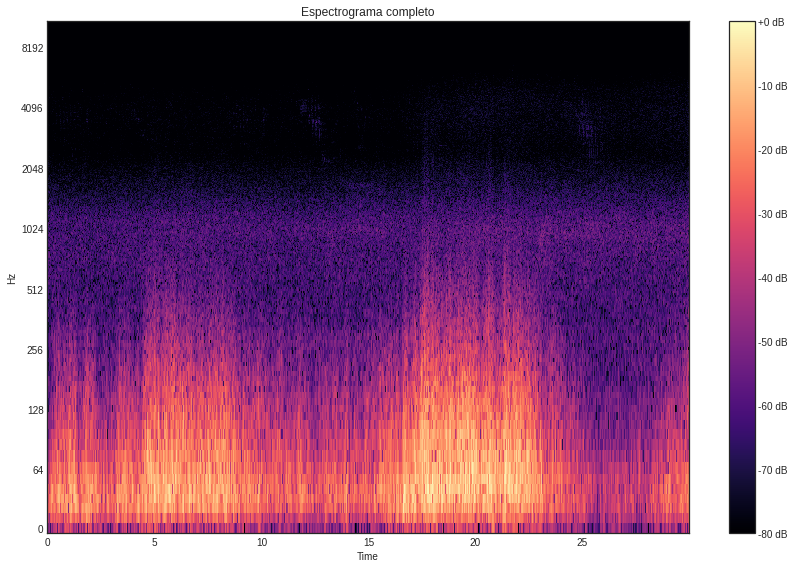

In [6]:
audio, sr = librosa.load(path)
espectrograma = librosa.stft(audio)
espectrograma_db = librosa.amplitude_to_db(abs(espectrograma), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(espectrograma_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma completo')
plt.tight_layout()
plt.show()

Código LBP aqui

In [11]:
labels = []
specs = []

path = './spec_janela2/'

j = 0
k = 0
for i in range(1170):
    aux = []
    if j == 78:
        j = 0
        k += 1
    path_total = path + 'class_' + classes[k] + '/' + str(i) + '/' 
    for l in range(6):
        path_img = path_total + str(l) + '.png'
        img = cv2.imread(path_img, 0)
        aux.append(img)
    specs.append(aux)
    # labels.append(classes[k])
    labels.append(classes_int[k])
    j += 1
    print(i, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [12]:
desc = LocalBinaryPatterns2(8, 2)
X = []

for spec in specs:
    aux = []
    for img in spec:
        hist = desc.describe(img)
        aux.append(hist)
    X.append(aux)

y = labels[:]

In [14]:
arq = open("./features_LBP_janela.txt", "w")

for i in range(len(X)):
    for t in X[i]:
        for j in range(len(t)):
            if j < len(t) - 1:
                arq.write(str(t[j]))
                arq.write(";")
            else:
                arq.write(str(t[j]))
                arq.write("|")
    arq.write(str(y[i]))
    arq.write("\n")

arq.close()


In [4]:
X2 = []
y2 = []

arq = open("./features_LBP_janela.txt", "r")
for linha in arq:
    aux = linha.split("|")
    lbp_local = []
    for i in range(len(aux)-1):
        classe_local = []
        aux2 = aux[i].split(";")
        for j in aux2:
            classe_local.append(float(j))
        lbp_local.append(classe_local)
    X2.append(lbp_local)
    y2.append(aux[len(aux)-1].replace("\n", ""))
arq.close()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.225, random_state=101)

In [6]:
print(len(X2))

1170


In [7]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

906
906
264
264


In [8]:
X_train2 = []
y_train2 = []

for i, train in enumerate(X_train):
    for j in train:
        X_train2.append(j)
        y_train2.append(y_train[i])
    
X_test2 = []
y_test2 = []

for i, train in enumerate(X_test):
    for j in train:
        X_test2.append(j)
        y_test2.append(y_test[i])

In [9]:
print(len(X_train2))
print(len(y_train2))
print(len(X_test2))
print(len(y_test2))

5436
5436
1584
1584


In [10]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
grid = GridSearchCV(SVC(probability=False), param_grid,
                    refit=True, verbose=5, cv=5)

grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.091 total time=   1.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.084 total time=   1.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.078 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.075 total time=   1.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.081 total time=   1.4s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.072 total time=   1.7s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.072 total time=   1.7s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.072 total time=   1.7s
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.072 total time=   1.7s
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.072 total time=   1.7s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.072 total time=   1.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             verbose=5)

In [11]:
# imprime o melhor parâmetro após o ajuste
print(grid.best_params_)

# imprime a aparência do nosso modelo após o ajuste de hiperparâmetros
print(grid.best_estimator_)

{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
SVC(C=100, kernel='poly')


In [12]:
grid_predictions = grid.predict(X_test2)

# print classification report
print(classification_report(y_test2, grid_predictions))

              precision    recall  f1-score   support

           0       0.71      0.59      0.65       138
           1       0.79      0.89      0.84       120
          10       0.75      0.89      0.81       114
          11       0.46      0.52      0.49       102
          12       0.41      0.28      0.34       102
          13       0.73      0.56      0.63       108
          14       0.60      0.62      0.61        90
           2       0.70      0.78      0.74        96
           3       0.83      0.80      0.82       120
           4       0.55      0.36      0.44       108
           5       0.59      0.84      0.70       108
           6       0.61      0.78      0.68       108
           7       0.77      0.57      0.66        84
           8       0.70      0.81      0.75        78
           9       0.75      0.71      0.73       108

    accuracy                           0.67      1584
   macro avg       0.66      0.67      0.66      1584
weighted avg       0.67   

In [13]:
matrix = confusion_matrix(y_test2, grid_predictions)
print("Acuracia por classe: ")
diagonal = matrix.diagonal()/matrix.sum(axis=1)
j = 0
print_classes = ["beach", "bus", "cafe/restaurant", "car", "city_center", "forest_path", "grocery_store",
                 "home", "library", "metro_station", "office", "park", "residential_area", "train", "tram"]

class_accuracies = diagonal * 100
mean_accuracy = np.mean(class_accuracies)
std_accuracy = np.std(class_accuracies)

for i in range(len(diagonal)):
    print(print_classes[j] + ": " + str(round(diagonal[i]*100, 2)))
    j += 1

print("Média de acurácia: " + str(round(mean_accuracy, 2)))
print("Desvio padrão de acurácia: " + str(round(std_accuracy, 2)))

print(matrix)

Acuracia por classe: 
beach: 59.42
bus: 89.17
cafe/restaurant: 88.6
car: 51.96
city_center: 28.43
forest_path: 55.56
grocery_store: 62.22
home: 78.12
library: 80.0
metro_station: 36.11
office: 84.26
park: 77.78
residential_area: 57.14
train: 80.77
tram: 71.3
Média de acurácia: 66.72
Desvio padrão de acurácia: 17.98
[[ 82   0   0  12   3   6   3   0   4   3  16   1   1   6   1]
 [  1 107   0   0   0   3   1   0   5   0   0   0   1   2   0]
 [  0   0 101   1   0   0   0   2   0   0   0   3   5   0   2]
 [  7   1   2  53  13   0   1   2   0   1  13   4   1   2   2]
 [  6   0   1  20  29   4   0   2   0  25   9   3   0   2   1]
 [  0  13   0   1   6  60  21   0   1   0   0   0   0   5   1]
 [  1   0   0   0   0   4  56   1   9   1   0  12   2   1   3]
 [  0   0   0   3   0   0   0  75   0   0   1  11   2   0   4]
 [  0  10   0   2   1   3   8   0  96   0   0   0   0   0   0]
 [  6   0   2  17  15   0   1   0   0  39  15   7   0   0   6]
 [ 10   0   1   3   0   0   1   0   0   0  91   0   0

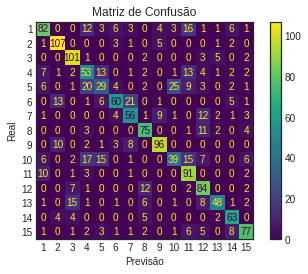

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[
                              i for i in range(1, 16)])
disp.plot()
plt.title("Matriz de Confusão")
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()